In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
from optuna.visualization import plot_optimization_history
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import plotly
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold

RANDOM_STATE = 3993
TEST_SIZE = 0.3
INTER_OPS = 0  # Independent non-blocking operations.
INTRA_OPS = 0  # Internal Matrix multiplication and reductions.

tf.config.threading.set_inter_op_parallelism_threads(INTER_OPS)
tf.config.threading.set_intra_op_parallelism_threads(INTRA_OPS)
tf.device('/cpu:0')

np.random.seed(seed=RANDOM_STATE)
tf.random.set_seed(seed=RANDOM_STATE)
random.seed(RANDOM_STATE)

2023-10-27 11:18:11.315242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nicholas/.conda/envs/optunaEnv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-27 11:18:14.737659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
DATASET = "adult"


path = "./dataset/" + DATASET + ".csv"
df = pd.read_csv(path)
NUM_CLASSES = np.unique(df['class']).size
scale = sklearn.preprocessing.StandardScaler()

X, y = df.drop(columns='class').values, df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [3]:
def create_model(trial):
    n_hidden = trial.suggest_int('n_hidden', 1, 5)
    hidden_units = trial.suggest_int('hidden_units', 32, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0, 0.6)
    hidden_activation = trial.suggest_categorical("hidden_activation", ["relu", "sigmoid", "tanh"])
    batch_norm = trial.suggest_categorical("batch_norm", ["True", "False"])
    activity_regularizer = trial.suggest_categorical("activity_regularizer", ["True", "False"])

    kernel_initializer = {
        "relu": "he_uniform",
        "selu": "lecun_normal",
        "elu": "he_uniform",
        "swish": "he_uniform",
    }.get(hidden_activation, "glorot_uniform")


    model = Sequential()
    
    model.add(
        Input(
            shape=X_train.shape[1:],
        )
    )
    
    for i in range(n_hidden):
        model.add(
            Dense(
                units=hidden_units,
                activation=hidden_activation,
                activity_regularizer=tf.keras.regularizers.L2(1e-5) if activity_regularizer else None,
                kernel_initializer=kernel_initializer,
            )
        )
        model.add(
            Dropout(dropout)
        )

        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

        hidden_units = int(hidden_units / 2)

        
    if NUM_CLASSES > 2:
        model.add(
            Dense(
                NUM_CLASSES,
                activation="softmax"
            )
        )

        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics='accuracy',
        )
    else:
        model.add(
            Dense(
                1,
                activation="sigmoid"
            )
        )

        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics='accuracy',
        )
    
    return model

In [4]:
def multi_stratified_kfold(X_train, y_train):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

    folds = list()
    for train_index, val_index in skf.split(X_train, y_train):
        # Get labels
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]
        
        # Append folds
        folds.append(
            (
                X_train[train_index],
                X_train[val_index],
                y_train_fold,
                y_val_fold,
            ),
        )

    return folds

In [5]:
def objective(trial):
    init_weights_pathname = "weights/" + DATASET + "/init_weights_" + str(trial.number)

    trial.set_user_attr("init_weights_pathname", init_weights_pathname)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min", restore_best_weights=False)

    model = create_model(trial)

    model.save_weights(init_weights_pathname)

    batch_size = trial.suggest_categorical("batch_size", [32, 40, 48, 56, 64])
    
    folds_results = defaultdict(list)

    for i, fold_split in enumerate(mskfolds):

        trial.set_user_attr("fold", i+1)

        X_train_fold, X_val_fold, y_train_fold, y_val_fold = fold_split
        
        model.load_weights(init_weights_pathname)

        trial.set_user_attr("fit", "in corso")

        history = model.fit(
            x=X_train_fold,
            y=y_train_fold,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=50,
            callbacks=[callback],
            verbose=0,
        )

        trial.set_user_attr("fit", "terminato")


        loss_fold, accuracy_fold = model.evaluate(
            X_val_fold, y_val_fold, verbose=0
        )


        folds_results["fold"].append(i)
        folds_results["test_loss"].append(loss_fold)
        folds_results["test_accuracy"].append(accuracy_fold)


        for k, v in history.history.items():
            folds_results[k].append(v[-1])

        min_num_folds = 2

        if i >= min_num_folds:
            intermediate_score = np.mean(folds_results["test_accuracy"])
            trial.report(intermediate_score, i - min_num_folds)
            if trial.should_prune():
                raise optuna.TrialPruned()

    result = np.mean(folds_results["test_accuracy"])

    return result

In [6]:
study_name = DATASET + "-study"
#storage_name = "sqlite:///Optuna Results/optuna-new.db"

storage_name = JournalStorage(JournalFileStorage("./optuna.log"))

mskfolds = multi_stratified_kfold(X_train, y_train)

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.DEBUG)

/tmp/ipykernel_216511/2822323427.py:4: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage_name = JournalStorage(JournalFileStorage("./optuna.log"))
[I 2023-10-27 11:18:16,692] Using an existing study with name 'adult-study' instead of creating a new one.


In [7]:
def delete_init_model_weights_callback(
    study: optuna.Study, trial: optuna.trial.FrozenTrial
):
    """Callback that removes initial weights of unoptimal models"""
    if study.best_trial.number != trial.number:
        os.remove(trial.user_attrs["init_weights_pathname"])

In [8]:
'''
study.optimize(
    objective,
    n_trials=256,
    n_jobs=-1,
    gc_after_trial=True,
    #callbacks=[delete_init_model_weights_callback],
)
'''

'\nstudy.optimize(\n    objective,\n    n_trials=256,\n    n_jobs=-1,\n    gc_after_trial=True,\n    #callbacks=[delete_init_model_weights_callback],\n)\n'

In [9]:
print(study.best_params)
print(study.best_value)

f = open("./" + DATASET + ".txt", "w")
f.write(str(study.best_params) + "\n")
f.write(str(study.best_value))
f.close()

{'n_hidden': 2, 'hidden_units': 211, 'learning_rate': 0.0008119015815876429, 'dropout': 0.025054480961881016, 'hidden_activation': 'sigmoid', 'batch_norm': 'True', 'activity_regularizer': 'True', 'batch_size': 48}
0.8519700229167938


/tmp/ipykernel_216511/1151491659.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_216511/1151491659.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/tmp/ipykernel_216511/1151491659.py:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


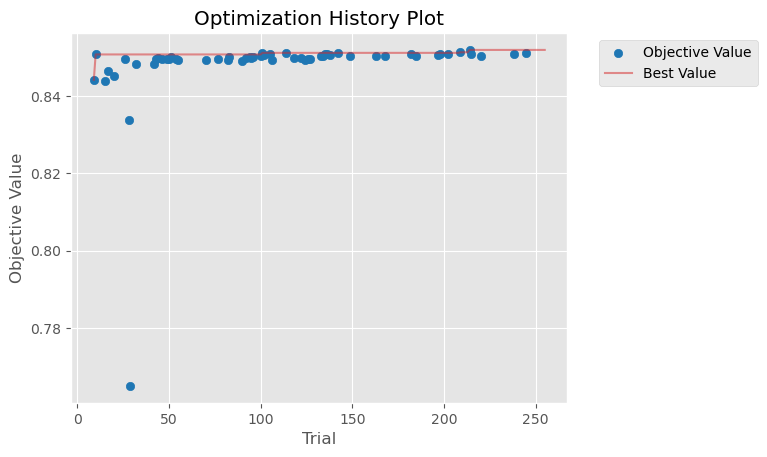

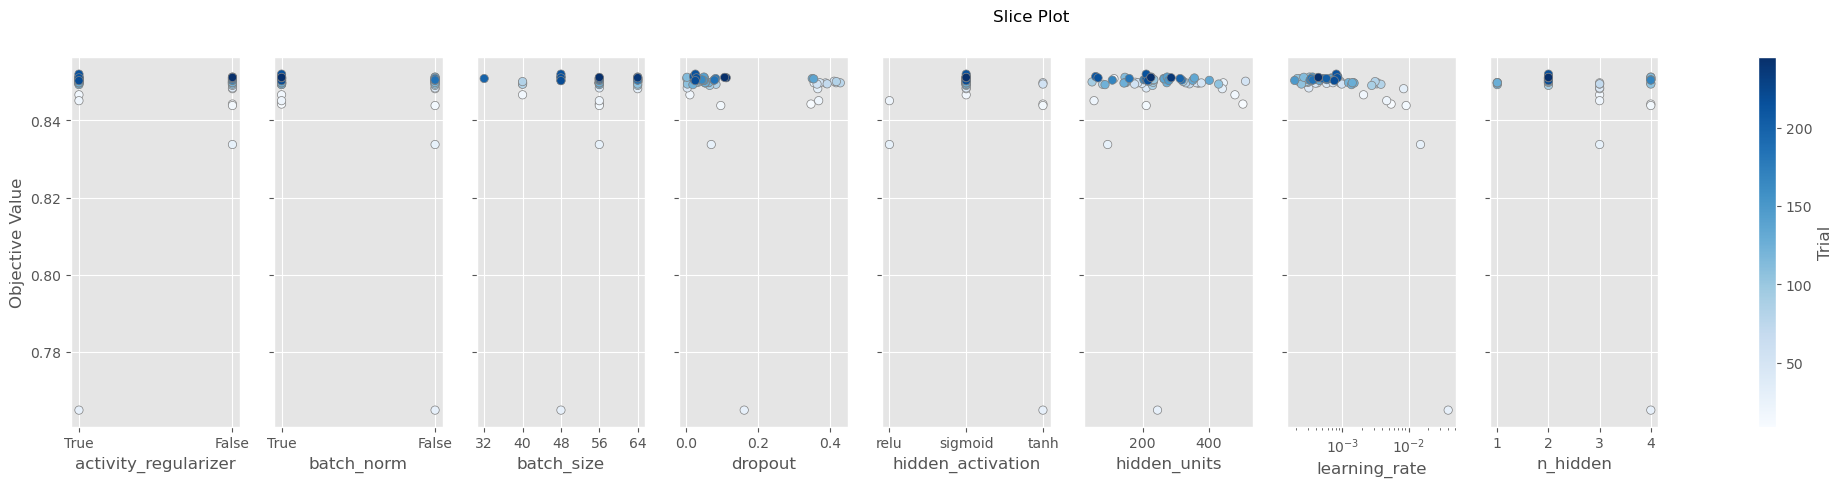

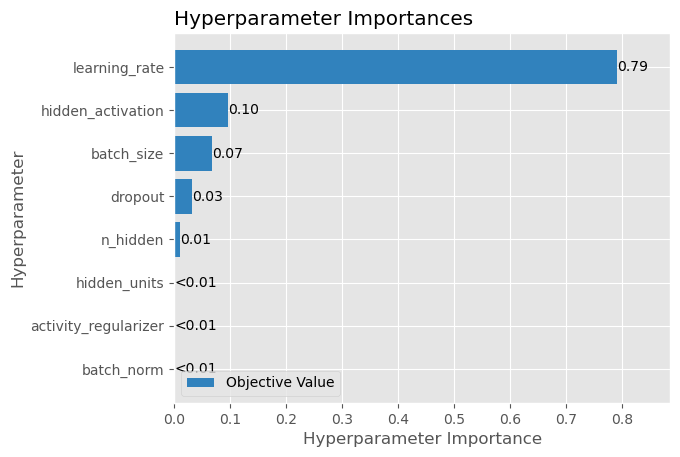

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig("images/" + DATASET + "_optimization_history.png", bbox_inches="tight")

optuna.visualization.matplotlib.plot_slice(study)
plt.savefig("images/" + DATASET + "_slice.png", bbox_inches="tight")

optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig("images/" + DATASET + "_param_importances.png", bbox_inches="tight")